In [1]:
import os
import argparse
import pickle
from functools import partial
from __future__ import annotations
from dataclasses import dataclass, field
from abc import ABC, abstractclassmethod
from typing import Dict, List, Tuple, Optional
from collections.abc import Callable, Iterable, Generator

import gdown
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import learn2learn as l2l
from learn2learn.data.transforms import NWays, KShots, LoadData, RemapLabels

/home/woreom/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
@dataclass
class ClassificationDataset(torch.utils.data.Dataset):
    """Wrapper on top of torch.utils.data.Dataset for differentiating test, train, val datasets."""
    
    X: torch.Tensor
    y: np.ndarray
    transform: Optional[Callable] = None,
    target_transform: Optional[Callable] = None,
    
    def __getitem__(self, idx):
        
        image = self.transform(self.X[idx]) if self.transform else self.X[idx]
        label = self.target_transform(self.y[idx]) if self.target_transform else self.y[idx]
        
        return image, label

    def __len__(self):
        return len(self.X)


@dataclass
class FewShotLearningModel(ABC):
    """Base Representation of a FewShot Learning Model."""
    
    # training few shot learning setting
    train_way: int
    train_shot: int
    train_query: int
    train_num_episode: int
    
    # testing and validation few shot learning setting
    test_way: int
    test_shot: int
    test_query: int
    test_num_episode: int
    
    gpu: int
    
    # general machine learning training settings
    epochs: Optional[int] = None
    batch_size: Optional[int] = None
    eval_step: Optional[int] = None 
    early_stop: Optional[bool] = None
    
    optimizer: Optional[Iterable[torch.nn.parameter.Parameter]] = None
    lr_scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None
    loss: Optional[Callable[[torch.Tensor, torch.Tensor, str, Optional[torch.Tensor],
                             Optional[bool], Optional[bool], Optional[float], Optional[int],
                             Optional[bool], Optional[bool], Optional[torch.Tensor],],
                            torch.Tensor,]] = None
    
    # training history
    hist: Optional[Dict[str, List]] = None
    
    
    def init_parsearges(self):
        """This function is for changing basic arguments of the class in training script."""
        
        help_dict = {
            'epochs': "number of epochs for training", 'num_episode':"number of episode per epoch", 'batch_size': "batch size for training", 'eval_step': "number of epochs before each evaluation",
            'early_stop': "stop training in case overfitting occurs", 'gpu': "", 'train_way': "number of training classes",
            'train_shot': "number of samples per class for training", 'train_query':"number of images to classify in training phase",
            'test_way': "number of test classes", 'test_shot': "number of samples per class for testing and validation phase",
            'test_query': "number of images to classify in testing and validation phase",
        }
        
        arg_dict = self.__dict__
        parser = argparse.ArgumentParser()
        for key in help_dict.keys():
            parser.add_argument('--'+key, default=arg_dict[key],
                               help= help_dict[key])
        kargs = parser.parse_args()
        kargs = {key: kargs.__dict__.get(key, arg_dict[key]) for key in arg_dict}
        self.__init__(**kargs)
    
    def is_trainable(self) -> (bool, List[str]):
        training_attributes = ["epochs", "batch_size", "eval_step", "early_stop", "optimizer", "lr_scheduler", "loss"]
        log = [f"argument {key} is not set" for key in training_attributes if self.__dict__[key] == None ]
        
        return True if log==[] else False, log
        
    
    @abstractclassmethod
    def predict(self, X: np.ndarray) -> None:
        """Predicts the out come of Matrix X."""
        pass
    
    @abstractclassmethod
    def save(self, path: str) -> None:
        pass
    
    @abstractclassmethod
    def load(self, path: str) -> None:
        pass
    
    @abstractclassmethod
    def data_loader(self, dataset: torch.utils.data.Dataset, mode: str):
        pass
    
    @abstractclassmethod
    def update_weights(self, X: np.ndarray, y: np.ndarray) -> None:
        """Updates the weights of the model after one step or epoch."""
        pass
    
    @abstractclassmethod
    def save_hist(self, X: np.ndarray, y: np.ndarray, i: int) -> None:
        """Saves the parameters of the model in between updates of training."""
        pass
    
    @abstractclassmethod
    def fit(self, X: np.ndarray, y: np.ndarray ) -> None:
        """trains the model using the vector features X and labels Y."""
        pass

class Convnet(nn.Module):

    def __init__(self, x_dim=3, hid_dim=64, z_dim=64):
        super().__init__()
        self.encoder = l2l.vision.models.CNN4Backbone(
            hidden_size=hid_dim,
            channels=x_dim,
            max_pool=True,
       )
        self.out_channels = 1600

    def forward(self, x):
        # print(x.shape)
        x = self.encoder(x)
        return x.view(x.size(0), -1)

In [4]:
def pairwise_distances_logits(a, b):
    n = a.shape[0]
    m = b.shape[0]
    logits = -((a.unsqueeze(1).expand(n, m, -1) -
                b.unsqueeze(0).expand(n, m, -1))**2).sum(dim=2)
    return logits


def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)

    
def download_from_gdrive(_id: str, output: str) -> None:
    gdown.download(id= _id, output= output)


def get_mini_magenet(root: str, mode: str, transform: Optional[Callable] = None, download: bool= False,
                     target_transform: Optional[Callable] = None) -> Dataset:
    """Mini ImageNet Dataset Loader for torch"""
    
    gdrive_id = {"test":'1wpmY-hmiJUUlRBkO9ZDCXAcIpHEFdOhD', "train":'1I3itTXpXxGV68olxM5roceUMG8itH9Xj',
                 "val":'1KY5e491bkLFqJDp0-UWou3463Mo8AOco'}
    
    pickle_file = os.path.join(root, f'mini-imagenet_{mode}.pkl')
    
    # download pkl file
    if not os.path.exists(pickle_file) and download:
        print(f"Downloading mini-imagenet_{model} at {pickle_file}")
        download_from_gdrive(_id=MiniImagenet.gdrive_id[mode], output=pickle_file)
        
    # open pkl file
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
    
    # create X and y
    X = torch.from_numpy(data["image_data"]).permute(0, 3, 1, 2).float()
    y = np.ones(X.shape[0])

    # dict of indexes to np.array
    for (i, key) in enumerate(data['class_dict'].keys()):
        for idx in data['class_dict'][key]:
            y[idx] = i

    return ClassificationDataset(X= X, y= y, transform= transform,
                                 target_transform= target_transform)

@dataclass
class PrototypicalNetwork(FewShotLearningModel):
    encoder: nn.Module= Convnet()
    
    optimizer: Optional[Iterable[torch.nn.parameter.Parameter]]= torch.optim.Adam
    lr_scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = torch.optim.lr_scheduler.StepLR
    loss: Optional[Callable[[torch.Tensor, torch.Tensor, str, Optional[torch.Tensor],
                             Optional[bool], Optional[bool], Optional[float], Optional[int],
                             Optional[bool], Optional[bool], Optional[torch.Tensor],],
                            torch.Tensor,]] = F.cross_entropy
    
    def save(self, path: str) -> None:
        pass
    
    def load(self, path: str) -> None:
        pass
    
    def predict(self, X: np.ndarray) -> None:
        """Predicts the out come of Matrix X."""
        pass
    
    def data_loader(self, dataset: torch.utils.data.Dataset, mode: str):
        def get_num_tasks(y):
            return max(y)
        
        mode_dataset = l2l.data.MetaDataset(dataset)
        mode_transforms = [
            NWays(mode_dataset, self.train_way if mode == "train" else self.test_way),
            KShots(mode_dataset, self.train_query + self.train_shot if mode == "train" else self.test_query + self.test_shot),
            LoadData(mode_dataset),
            RemapLabels(mode_dataset),
        ]
        
        mode_tasks = l2l.data.TaskDataset(mode_dataset, task_transforms=mode_transforms,
                                          num_tasks= get_num_tasks(dataset.y) if mode!="train" else -1)
        mode_loader = DataLoader(mode_tasks, pin_memory=True, shuffle=True, )
        
        return mode_loader
    
    def meta_fit(model, batch, ways, shot, query_num, metric=None, device=None):
        pass
    
    def encoding_fit():
        pass
    
    def update_weights(self, X: np.ndarray, y: np.ndarray) -> None:
        """Updates the weights of the model after one step or epoch."""
        pass
    
    def save_hist(self, X: np.ndarray, y: np.ndarray, i: int) -> None:
        """Saves the parameters of the model in between updates of training."""
        pass
    
    def eval_model(self, num_episode, data_loader, optimizer, metric, device, mode):
        loss_ctr = 0
        n_loss = 0
        n_acc = 0
        for i in range(num_episode):
            batch = next(iter(data_loader))
            if mode == "train":
                optimizer.zero_grad()
            
            loss, acc = fast_adapt(self.encoder,
                                   batch,
                                   self.train_way if mode == "train" else self.test_way ,
                                   self.train_shot if mode == "train" else self.test_shot,
                                   self.train_query if mode == "train" else self.test_query,
                                   metric=metric,
                                   device=device)

            loss_ctr += 1
            n_loss += loss.item()
            n_acc += acc
            if mode == "train":
                loss.backward()
                optimizer.step()
                
        return n_loss/loss_ctr, n_acc/loss_ctr
    
    def fit(self, get_dataset: Callable,
            optimizer: Optional[Iterable[torch.nn.parameter.Parameter]]= None,
            lr_scheduler: Optional[torch.optim.lr_scheduler._LRScheduler]= None,
            loss: Optional[Callable[[torch.Tensor, torch.Tensor, str, Optional[torch.Tensor],
                                    Optional[bool], Optional[bool], Optional[float], Optional[int],
                                    Optional[bool], Optional[bool], Optional[torch.Tensor],
                                    ], torch.Tensor,]]= None,
            lr_step_size: int = 5,
            ) -> None:
        
        # print("aaa")
        trainable, log = self.is_trainable()
        if not trainable:
            raise Exception(log[0])
            
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder.to(device)
        
        optimizer = self.optimizer(self.encoder.parameters(), lr=0.001)
        #divide the learning rate by 2 at each epoch, as suggested in paper
        lr_scheduler = self.lr_scheduler(optimizer, step_size=lr_step_size, gamma=0.5, last_epoch=-1)
        
        train_loader = self.data_loader(dataset= get_dataset(mode= 'train'), mode= 'train')
        val_loader = self.data_loader(dataset= get_dataset(mode= 'val'), mode= 'val')
        test_loader = self.data_loader(dataset= get_dataset(mode= 'test'), mode= 'test')
        
        

        for epoch in range(1, self.epochs+1,):
            # print("aaa")
            self.encoder.train()
            acc, loss = self.eval_model(num_episode=self.train_num_episode, data_loader= train_loader, optimizer=optimizer,
                            metric=None, device=device, mode="train")
            print(f'train: epoch {epoch}, loss={acc:.4f} acc={loss:.4f}')
            
            if epoch % self.eval_step == 0:
                
                self.encoder.eval()
                acc, loss = self.eval_model(num_episode=self.test_num_episode, data_loader= val_loader, optimizer=None,
                            metric=None, device=device, mode="val")
                print(f'eval: epoch {epoch}, loss={acc:.4f} acc={loss:.4f}')
            lr_scheduler.step()

            
        acc, loss = self.eval_model(num_episode=self.test_num_episode, data_loader= test_loader, optimizer=None,
                            metric=None, device=device, mode="test")
        print(f'test: epoch {epoch}, loss={acc:.4f} acc={loss:.4f}')

def fast_adapt(model, batch, ways, shot, query_num, flatten=False, metric=None, device=None):
    if metric is None:
        metric = pairwise_distances_logits
    if device is None:
        device = model.device()
    data, labels = batch
    data = data.to(device)
    labels = labels.to(device)
    n_items = shot * ways

    # Sort data samples by labels
    # TODO: Can this be replaced by ConsecutiveLabels ?
    sort = torch.sort(labels)
    data = data.squeeze(0)[sort.indices].squeeze(0)
    labels = labels.squeeze(0)[sort.indices].squeeze(0)

    # Compute support and query embeddings
    # print(data.shape)
    # data= data.reshape((data.shape[0], np.prod(data.shape[1:]))) if flatten else data
    # print(data.shape)
    embeddings = model.encoder(data)
    support_indices = np.zeros(data.size(0), dtype=bool)
    selection = np.arange(ways) * (shot + query_num)
    for offset in range(shot):
        support_indices[selection + offset] = True
    query_indices = torch.from_numpy(~support_indices)
    support_indices = torch.from_numpy(support_indices)
    support = embeddings[support_indices]
    support = support.reshape(ways, shot, -1).mean(dim=1)
    query = embeddings[query_indices]
    labels = labels[query_indices].long()

    logits = metric(query, support)
    loss = F.cross_entropy(logits, labels)
    acc = accuracy(logits, labels)
    return loss, acc

images.shape: torch.Size([1, 50, 3, 84, 84])
labels.shape: torch.Size([1, 50])
0  0  0  0


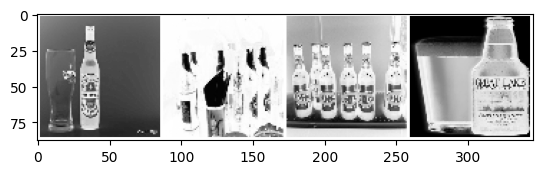

In [5]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataset = get_mini_magenet(mode= 'train', root="../../datasets/mini_imagenet_temp/",
                      transform=None, target_transform=None, download=False)   

mode_dataset = l2l.data.MetaDataset(dataset)
mode_transforms = [
    NWays(mode_dataset, 5),
    KShots(mode_dataset, 5+5),
    LoadData(mode_dataset),
    RemapLabels(mode_dataset),
]

mode_tasks = l2l.data.TaskDataset(mode_dataset, task_transforms=mode_transforms,
                                  num_tasks= max(dataset.y))

mode_loader = DataLoader(mode_tasks, pin_memory=True, shuffle=True, )
# print(mode_loader)
images, labels = next(iter(mode_loader))
# print(f"training_loader.shape: {mode_loader.shape}")
print(f"images.shape: {images.shape}")
print(f"labels.shape: {labels.shape}")

images = images.reshape([50, 3, 84, 84])
labels = labels.reshape(50)
# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images[:4])
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(f"{label}" for i, label in enumerate(labels[:4])))

# Test

In [6]:
# print(f"\n ================== lr_step_size = {i} ================== \n")
model = PrototypicalNetwork(encoder= Convnet(), epochs= 25, train_num_episode=1000, test_num_episode= 100, train_way= 5, train_shot= 5, train_query= 1,
                            test_way= 5, test_shot= 5, test_query= 1, gpu= 1, batch_size=8,
                            eval_step= 5, early_stop= True,)

get_dataset = partial(get_mini_magenet, root="../../datasets/mini_imagenet_temp/",
                      transform=None, target_transform=None, download=False)

model.fit(get_dataset=get_dataset, lr_step_size=10)

train: epoch 1, loss=3.9894 acc=0.4338
train: epoch 2, loss=1.3324 acc=0.4668
train: epoch 3, loss=1.2747 acc=0.4944
train: epoch 4, loss=1.2162 acc=0.5190
train: epoch 5, loss=1.1770 acc=0.5404
eval: epoch 5, loss=1.3090 acc=0.4960
train: epoch 6, loss=1.1781 acc=0.5390
train: epoch 7, loss=1.1501 acc=0.5474
train: epoch 8, loss=1.1371 acc=0.5580
train: epoch 9, loss=1.0929 acc=0.5708
train: epoch 10, loss=1.0817 acc=0.5714
eval: epoch 10, loss=1.2858 acc=0.4780
train: epoch 11, loss=1.0090 acc=0.6034
train: epoch 12, loss=0.9923 acc=0.6148
train: epoch 13, loss=0.9727 acc=0.6206
train: epoch 14, loss=0.9747 acc=0.6202
train: epoch 15, loss=0.9621 acc=0.6304
eval: epoch 15, loss=1.1594 acc=0.5600
train: epoch 16, loss=0.9268 acc=0.6452
train: epoch 17, loss=0.9246 acc=0.6392
train: epoch 18, loss=0.9276 acc=0.6442
train: epoch 19, loss=0.9165 acc=0.6466
train: epoch 20, loss=0.9202 acc=0.6518
eval: epoch 20, loss=1.1057 acc=0.5280
train: epoch 21, loss=0.8373 acc=0.6832
train: epoch 2

# Test On Backer Hughes Dataset

In [9]:
from torchvision import datasets, transforms
def get_baker_dataset(path: str= "../../datasets/BakersHuge/",
                        mode: str= "train") -> torch.utils.data.Dataset:
    
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Resize((96,96)),
         # transforms.Normalize((0.5), (0.5))
        ])

    # transform = transforms.ToTensor()

    dataset = datasets.ImageFolder(path+f'/{mode}/',
                                        transform=transform)
    dataset.y = [6]
    
    return dataset

In [11]:
# print(f"\n ================== lr_step_size = {i} ================== \n")
model = PrototypicalNetwork(encoder= Convnet(), epochs= 25, train_num_episode=1000, test_num_episode= 100, train_way= 5, train_shot= 1, train_query= 3,
                            test_way= 3, test_shot= 1, test_query= 3, gpu= 1, batch_size=8,
                            eval_step= 5, early_stop= True,)

get_dataset = partial(get_baker_dataset, path="../../datasets/BakersHuge/",)

model.fit(get_dataset=get_dataset, lr_step_size=10)

train: epoch 1, loss=6.5414 acc=0.2427
train: epoch 2, loss=1.5547 acc=0.3003
train: epoch 3, loss=1.4021 acc=0.3780
train: epoch 4, loss=1.3253 acc=0.4149
train: epoch 5, loss=1.2874 acc=0.4317


ValueError: Sample larger than population or is negative

In [20]:
from torchsummary import summary
summary(Convnet().cuda(), (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
       BatchNorm2d-2           [-1, 64, 96, 96]             128
              ReLU-3           [-1, 64, 96, 96]               0
         MaxPool2d-4           [-1, 64, 48, 48]               0
         ConvBlock-5           [-1, 64, 48, 48]               0
            Conv2d-6           [-1, 64, 48, 48]          36,928
       BatchNorm2d-7           [-1, 64, 48, 48]             128
              ReLU-8           [-1, 64, 48, 48]               0
         MaxPool2d-9           [-1, 64, 24, 24]               0
        ConvBlock-10           [-1, 64, 24, 24]               0
           Conv2d-11           [-1, 64, 24, 24]          36,928
      BatchNorm2d-12           [-1, 64, 24, 24]             128
             ReLU-13           [-1, 64, 24, 24]               0
        MaxPool2d-14           [-1, 64,